In [ ]:
import pandas as pd
import gzip
import json
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import defaultdict
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = "/content/drive/MyDrive/AIHW/AS2/renttherunway_final_data.json.gz"

In [ ]:
clean_dataset_path = "/content/drive/MyDrive/AIHW/AS2/caius_data_clean.csv"

In [ ]:
basic_stats_path = "/content/drive/MyDrive/AIHW/AS2/caius_data_basic_stats.csv"

In [ ]:
#   ========================== Data Preaparation ==========================

In [ ]:
def height_to_inches(height):
    # Check if height is a string
    if isinstance(height, str):
        # Convert height in format '5\' 8"' to total inches
        feet, inches = height.split('\' ')
        return int(feet) * 12 + int(inches.replace('"', ''))
    else:
        # If height is not a string, keep it as None (or as it is)
        return None

def weight_to_lbs(weight):
    # Check if height is a string
    if isinstance(weight, str):
        # Convert height in format '5\' 8"' to total inches
        return float(weight.replace('lbs', ''))
    else:
        # If height is not a string, keep it as None (or as it is)
        return None

def save_basic_stats(basic_stats, output_path):
  df = pd.DataFrame(basic_stats)
  df.to_csv(output_path, index=False)

def create_clean_dataset(dataset_path,output_path):
  compressed_file = gzip.open(dataset_path)
  dataset = [json.loads(line) for line in compressed_file]
  user = set()
  for i in dataset:
    if i['user_id'] is None:
      print("Containing null user")
    user.add(i['user_id'])
  print("Num of unique user: "+str(len(user)))
  compressed_file.close()
  df = pd.DataFrame(dataset)
  columns_to_analyze = ['fit', 'user_id', 'item_id', 'body type',\
              'category', 'height', 'size', 'age', \
              'review_date', 'rating', 'weight', 'bust size','review_text']
  df = df[columns_to_analyze]
  # Data type conversion
  df['age'] = pd.to_numeric(df['age'], errors='coerce')
  df['size'] = pd.to_numeric(df['size'], errors='coerce')
  df['height'] = df['height'].apply(height_to_inches)
  df['weight'] = df['weight'].apply(weight_to_lbs)
  # Convert the "review_date"
  df['review_date'] = pd.to_datetime(df['review_date'], errors='coerce', infer_datetime_format=True)

  # Convert to categorical data
  categorical_columns = ['fit', 'item_id', 'body type', 'category','bust size']
  for col in categorical_columns:
      df[col] = df[col].astype('category')

  df.to_csv(output_path, index=False)
  return df

In [ ]:
# Data loading and preparation
df = None
if not os.path.exists(clean_dataset_path):
  df = create_clean_dataset(dataset_path, clean_dataset_path)
else:
  df = pd.read_csv(clean_dataset_path)

192544
105571


In [ ]:
basic_stats = defaultdict()

In [ ]:
basic_stats['Data Records Count'] = len(df)
basic_stats['Missing Values Count'] = df.isnull().sum()
basic_stats['Missing Values by Percentage'] = (basic_stats['Missing Values Count']/len(df)*100)

In [ ]:
basic_stats

defaultdict(None,
            {'Data Records Count': 192544,
             'Missing Values Count': fit                0
             user_id            0
             item_id            0
             body type      14637
             category           0
             height           677
             size               0
             age              960
             review_date        0
             rating            82
             weight         29982
             bust size      18411
             review_text        0
             dtype: int64,
             'Missing Values by Percentage': fit             0.000000
             user_id         0.000000
             item_id         0.000000
             body type       7.601899
             category        0.000000
             height          0.351608
             size            0.000000
             age             0.498587
             review_date     0.000000
             rating          0.042588
             weight         15.571

In [ ]:
basic_stats

defaultdict(None,
            {'Data Records Count': 192544,
             'Missing Values Count': fit                0
             user_id            0
             item_id            0
             body type      14637
             category           0
             height           677
             size               0
             age              960
             review_date        0
             rating            82
             weight         29982
             bust size      18411
             review_text        0
             dtype: int64,
             'Missing Values by Percentage': fit             0.000000
             user_id         0.000000
             item_id         0.000000
             body type       7.601899
             category        0.000000
             height          0.351608
             size            0.000000
             age             0.498587
             review_date     0.000000
             rating          0.042588
             weight         15.571

In [ ]:
# Get Item2User and User2Item
user2Item = df.groupby('user_id')['item_id'].apply(list).to_dict()
item2User = df.groupby('item_id')['user_id'].apply(list).to_dict()
user_purchase_counts = df.groupby('user_id')['item_id'].nunique()
average_clothes_per_user = user_purchase_counts.mean()
purchase_distribution = user_purchase_counts.value_counts().sort_index()
basic_stats['Average Cloth Rented Per User'] = average_clothes_per_user
basic_stats['User Count'] = len(user2Item)
basic_stats['Item Count'] = len(item2User)

In [1]:
# Count the number of users in each purchase group, considering only 0 to 8 and 'other'
purchase_counts = basic_stats['User Count']
purchase_counts_clipped = purchase_counts.apply(lambda x: x if x <= 8 else 'other')
grouped_counts = purchase_counts_clipped.value_counts()

# Initialize a Series to hold percentages for groups 0 to 8 and 'other'
percentages_for_plot = pd.Series(index=[str(i) for i in range(9)] + ['other'], dtype=float).fillna(0)

# Calculate the percentages and update the Series created above
for group, count in grouped_counts.iteritems():
    group = str(group)  # Ensure the group is a string, because indices are strings
    percentages_for_plot[group] = (count / basic_stats['User Count']) * 100

# Plotting the distribution
bars = plt.bar(percentages_for_plot.index, percentages_for_plot.values)

# Annotate each bar with the percentage value
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f}%", va='bottom', ha='center')

plt.xlabel('Cloth Buying Count Group')
plt.ylabel('Percentage of Users (%)')
plt.title('Percentage Distribution of Cloth Buying Count per User')
plt.grid(True, which="both", ls="--", linewidth=0.5)  # Add a grid for easier reading
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()


NameError: name 'basic_stats' is not defined

In [ ]:
# Data visulization

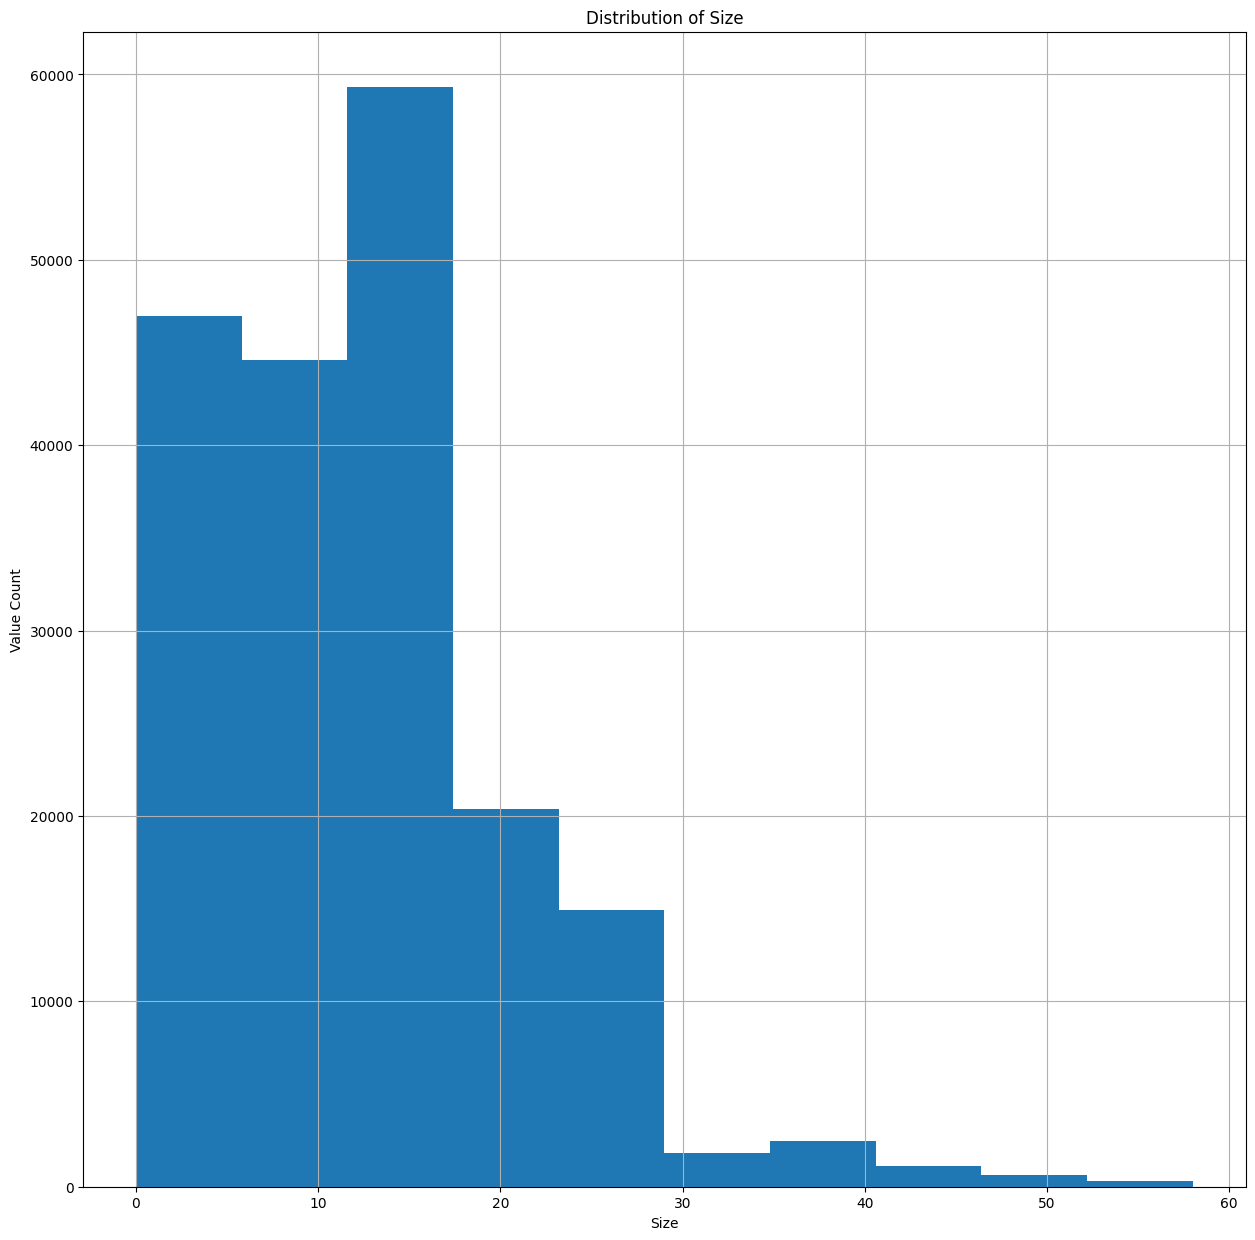

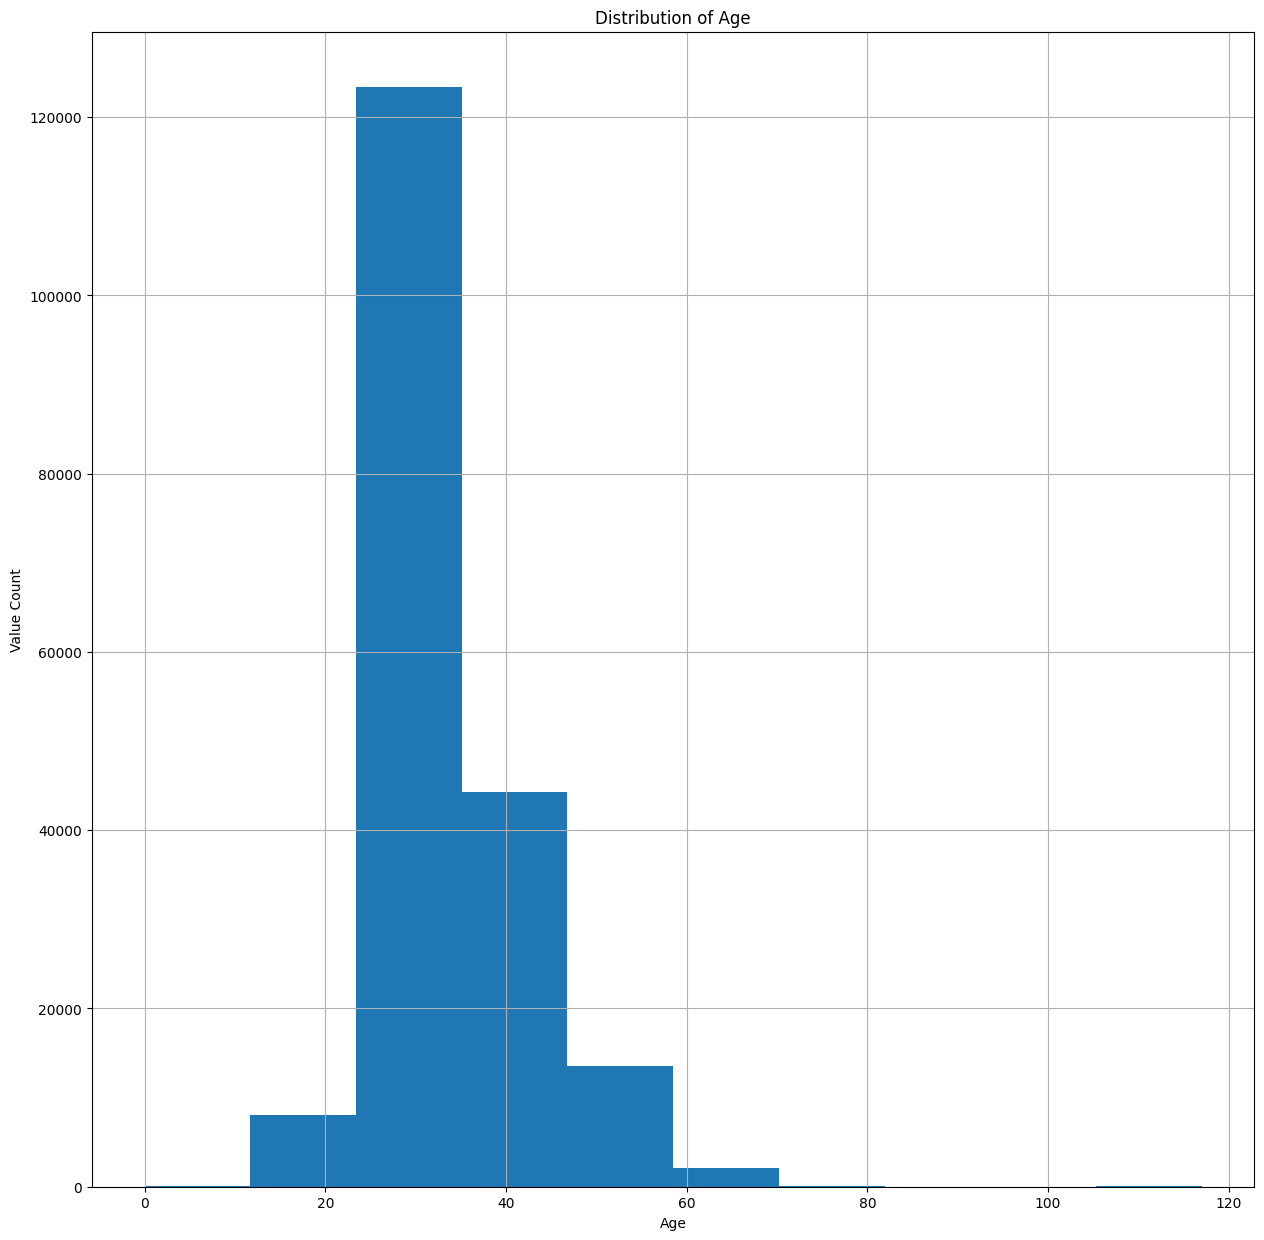

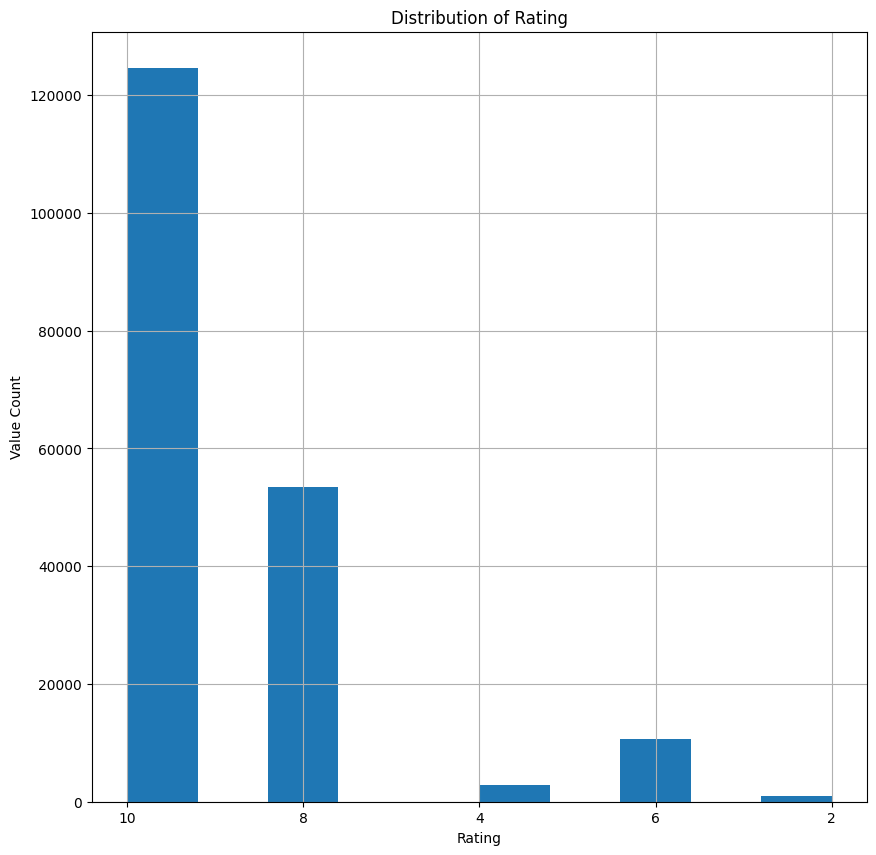

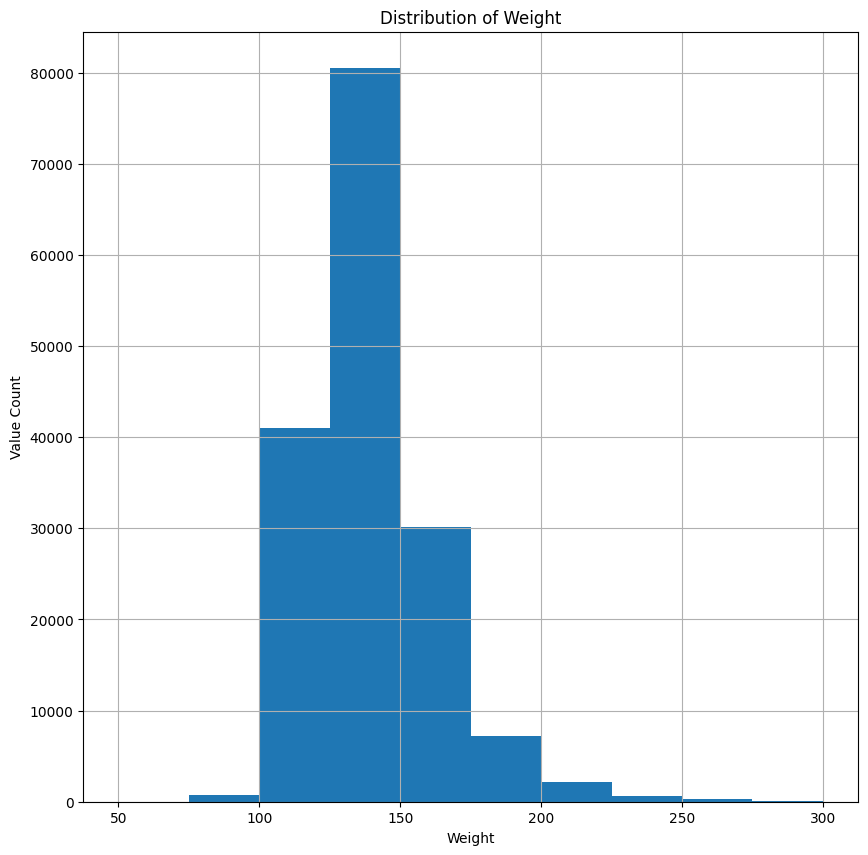

In [ ]:
size_df = df['size']
size_df.hist(figsize=(15,15))
plt.title('Distribution of Size')
plt.xlabel('Size')
plt.ylabel('Value Count')
plt.show()

size_df = df['age']
size_df.hist(figsize=(15,15))
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Value Count')
plt.show()

size_df = df['rating']
size_df.hist(figsize=(10,10))
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Value Count')
plt.show()

size_df = df['weight']
size_df.hist(figsize=(10,10))
plt.title('Distribution of Weight')
plt.xlabel('Weight')
plt.ylabel('Value Count')
plt.show()

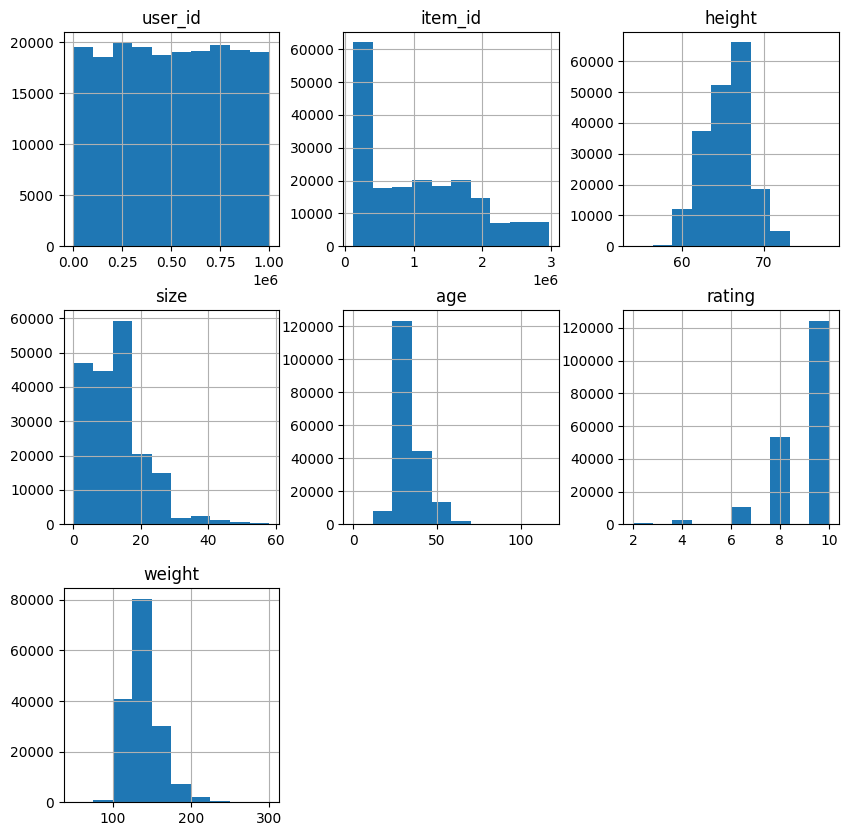

In [ ]:
df.hist(figsize=(10, 10))
plt.show()

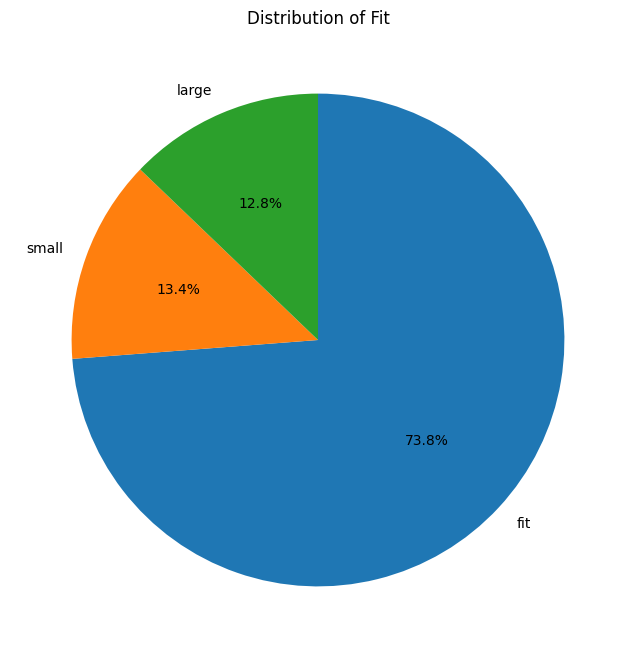

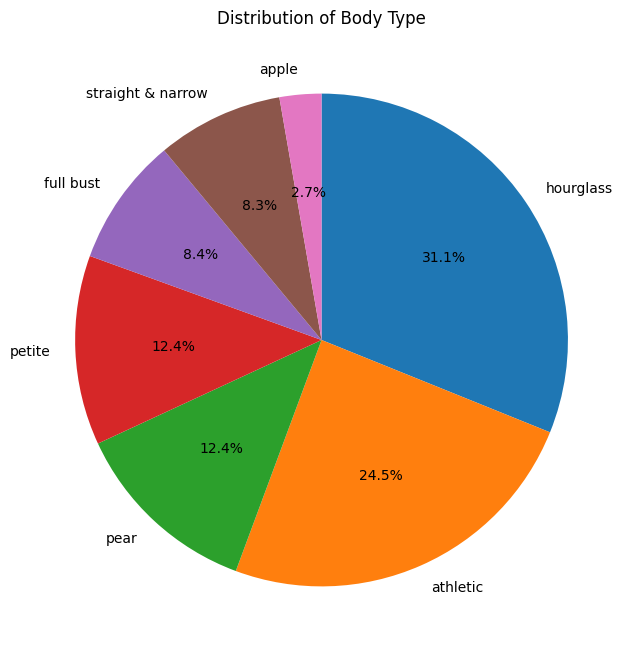

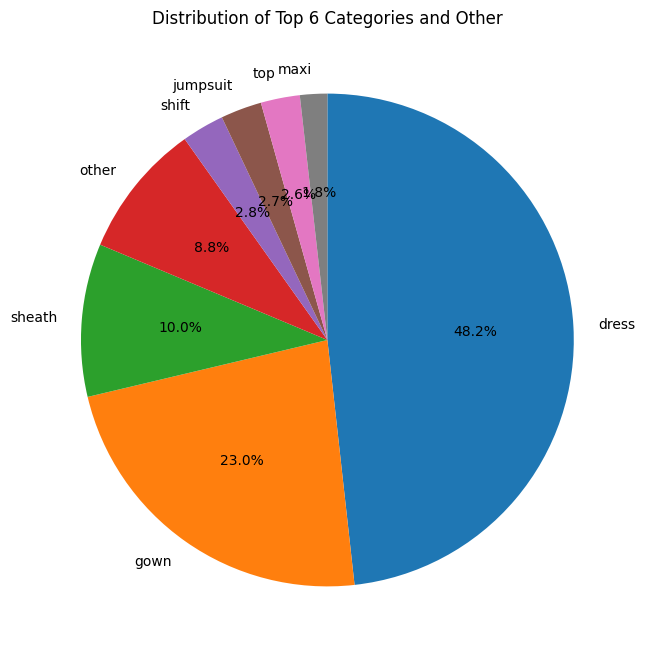

In [ ]:
# Category data Basic Stats
top_6_categories = df['category'].value_counts().head(7).index
df['category_grouped'] = df['category'].apply(lambda x: x if x in top_6_categories else 'other')

# Plotting the 'fit' feature
fit_counts = df['fit'].value_counts()
plt.figure(figsize=(8, 8))
fit_counts.plot.pie(autopct='%1.1f%%', startangle=90, counterclock=False)
plt.title('Distribution of Fit')
plt.ylabel('')  # Hide the y-label
plt.show()

# Plotting the 'body_type' feature
body_type_counts = df['body type'].value_counts()
plt.figure(figsize=(8, 8))
body_type_counts.plot.pie(autopct='%1.1f%%', startangle=90, counterclock=False)
plt.title('Distribution of Body Type')
plt.ylabel('')  # Hide the y-label
plt.show()

# Plotting the 'category_grouped' feature
category_counts = df['category_grouped'].value_counts()
plt.figure(figsize=(8, 8))
category_counts.plot.pie(autopct='%1.1f%%', startangle=90, counterclock=False)
plt.title('Distribution of Top 6 Categories and Other')
plt.ylabel('')  # Hide the y-label
plt.show()

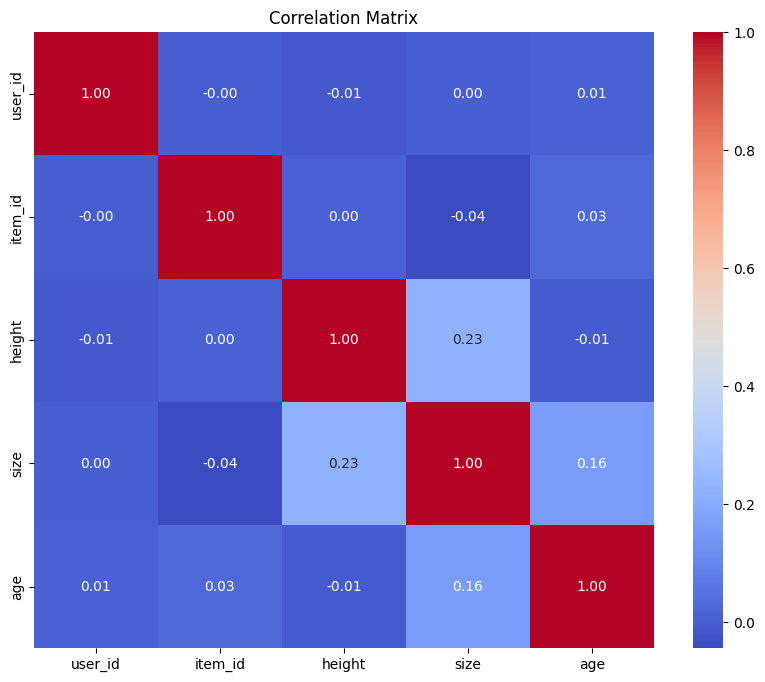

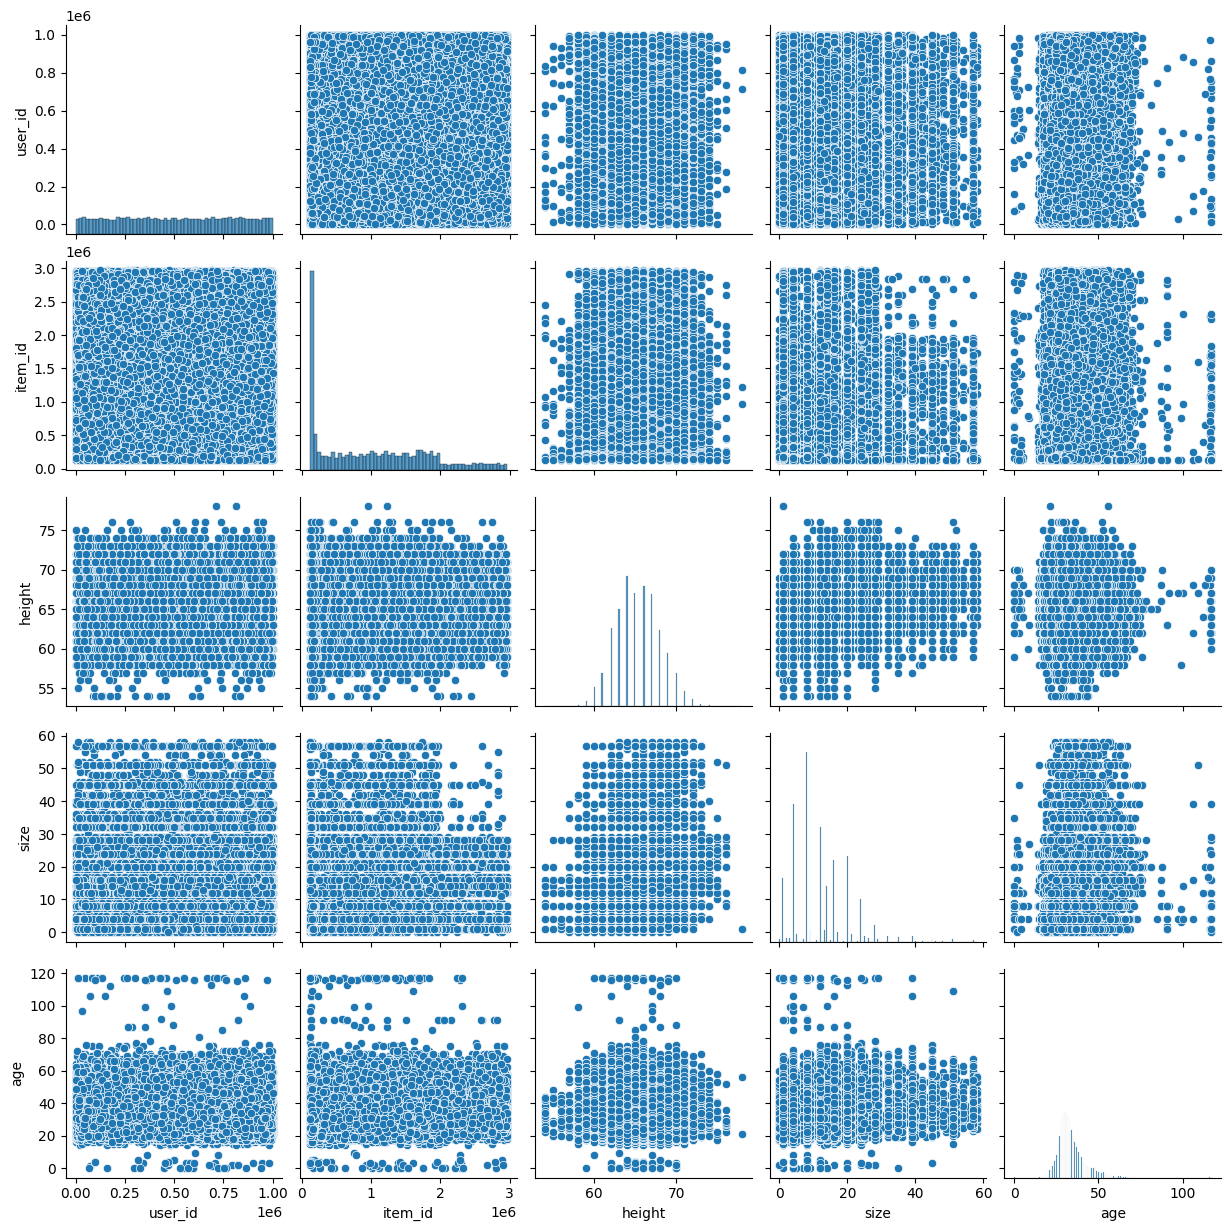

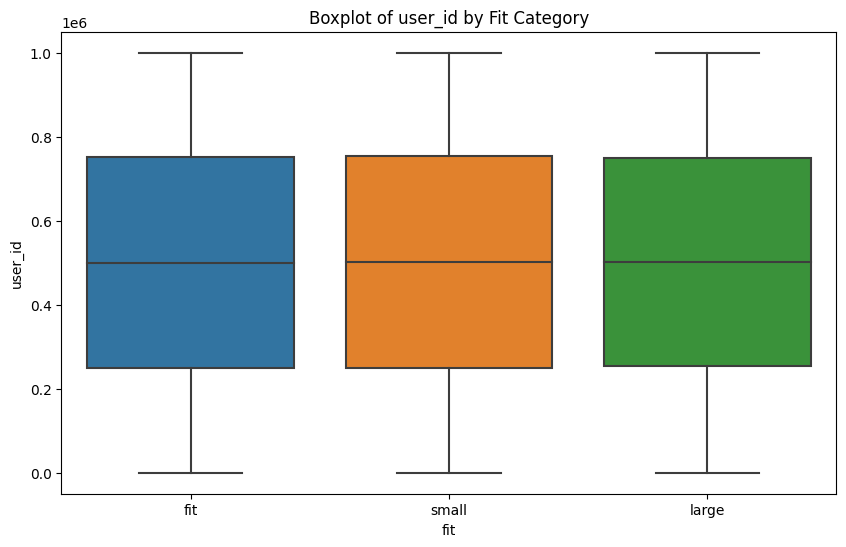

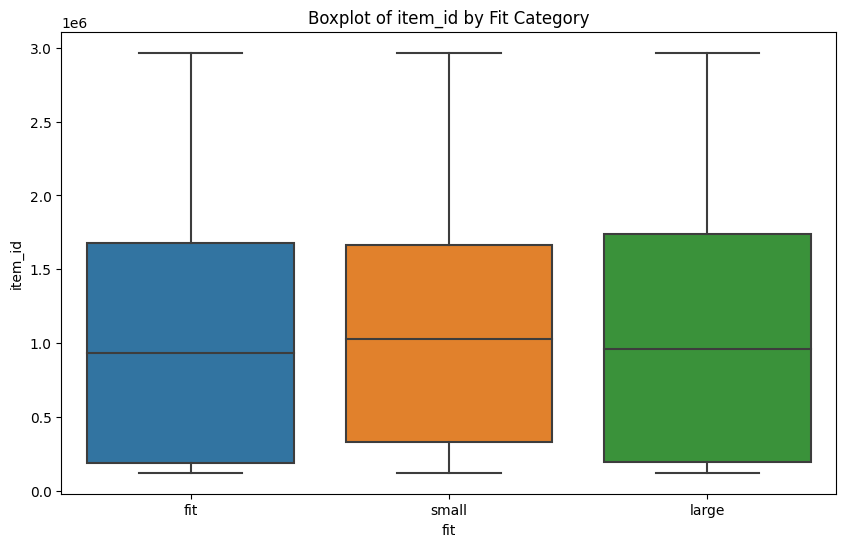

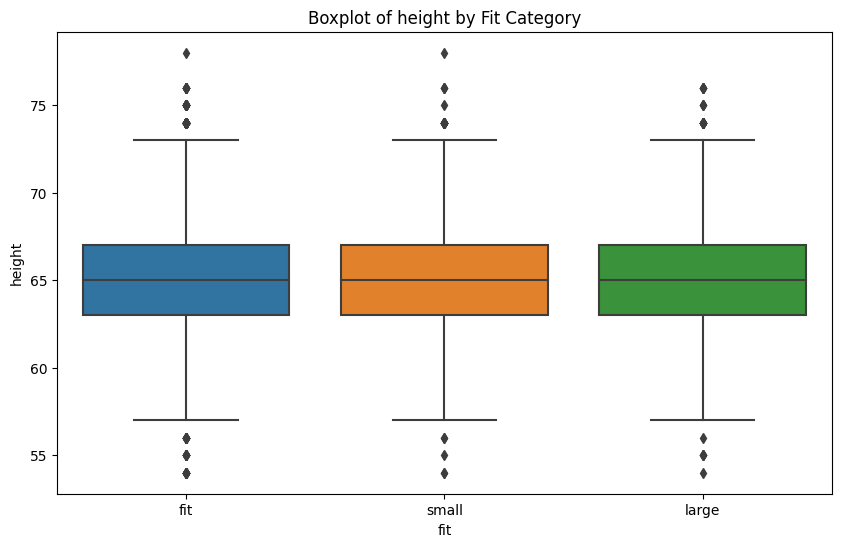

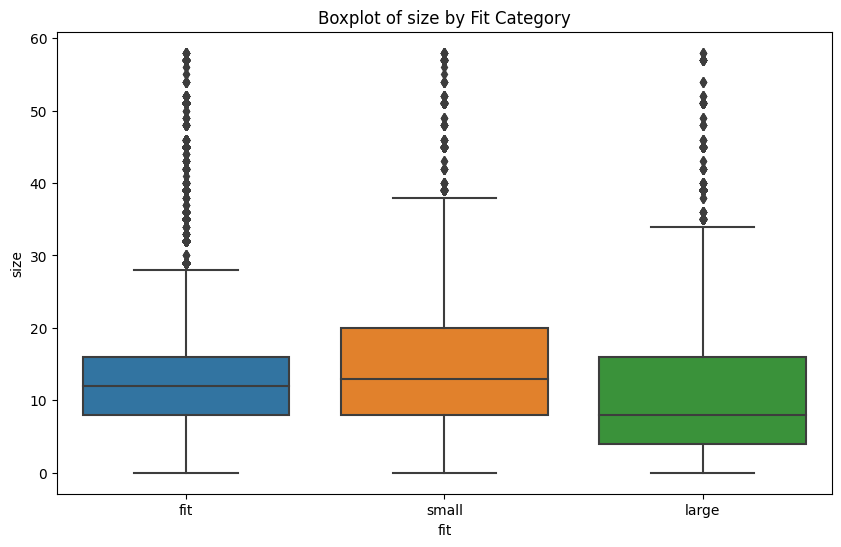

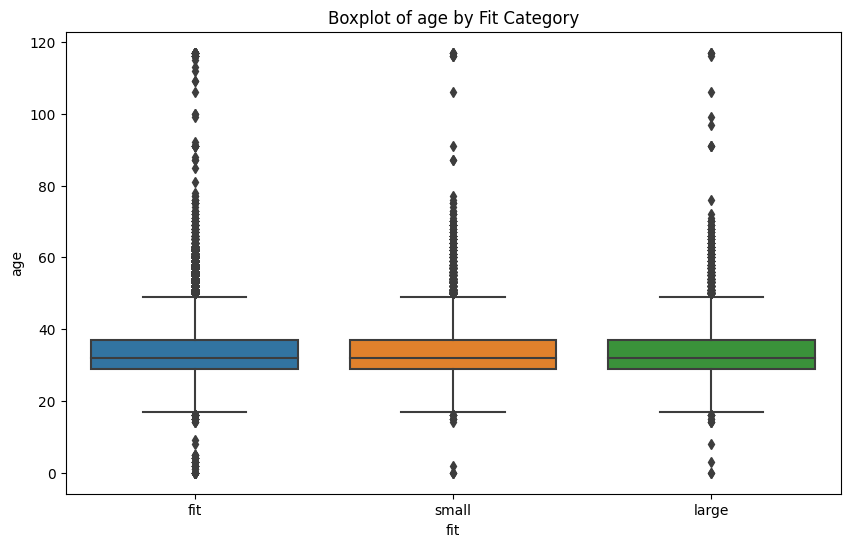

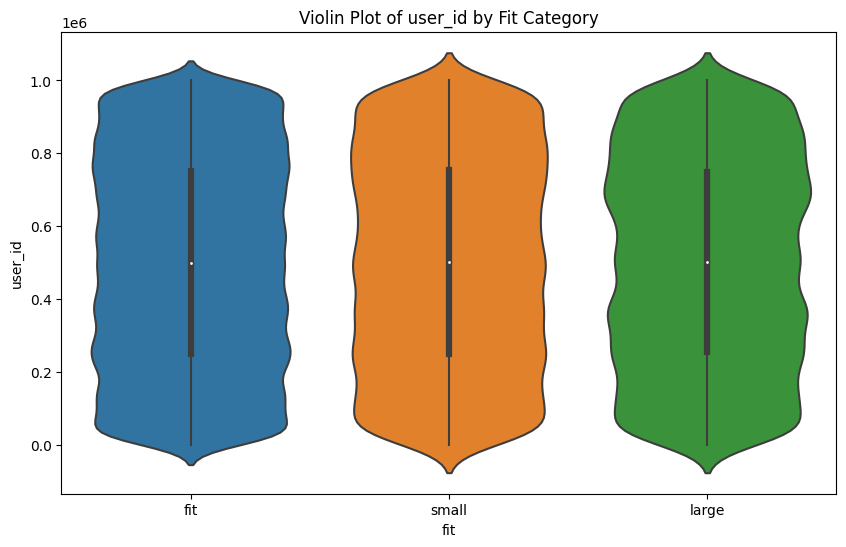

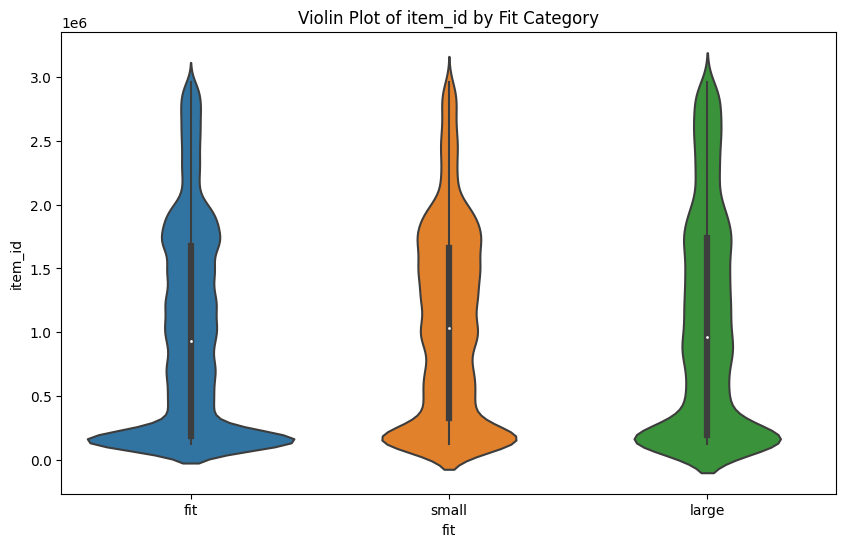

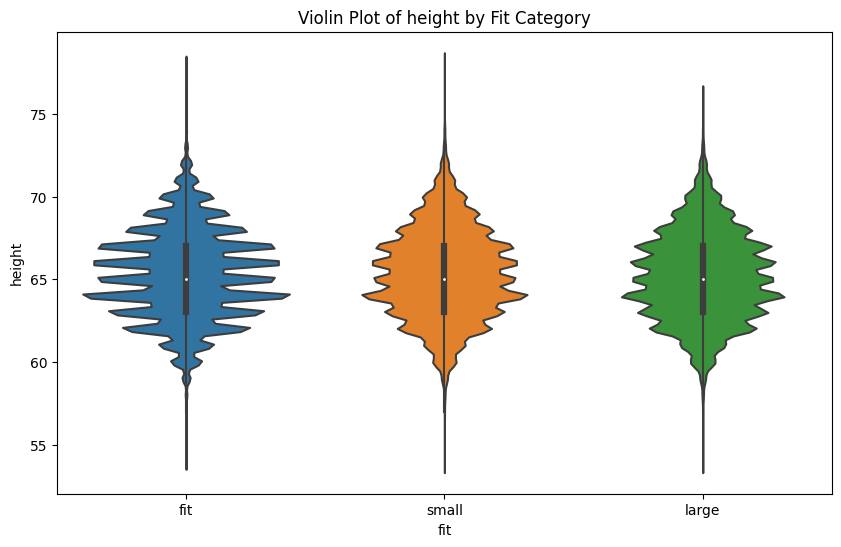

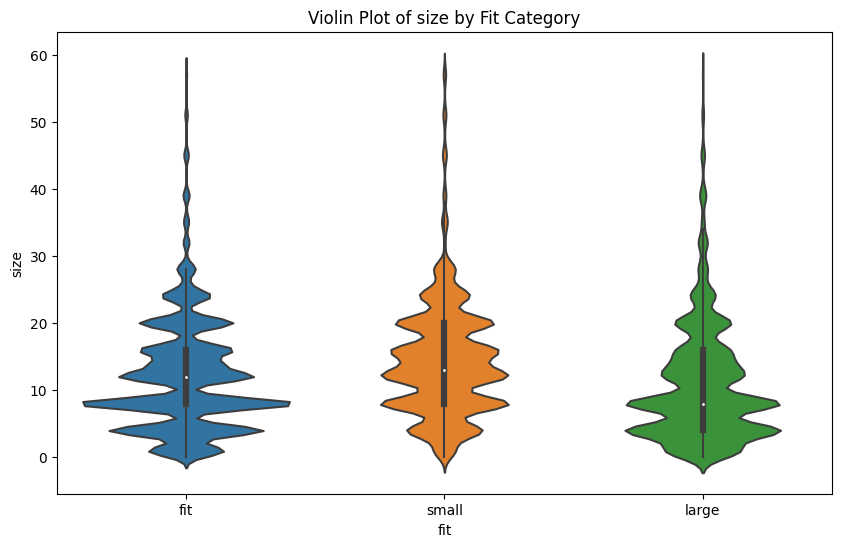

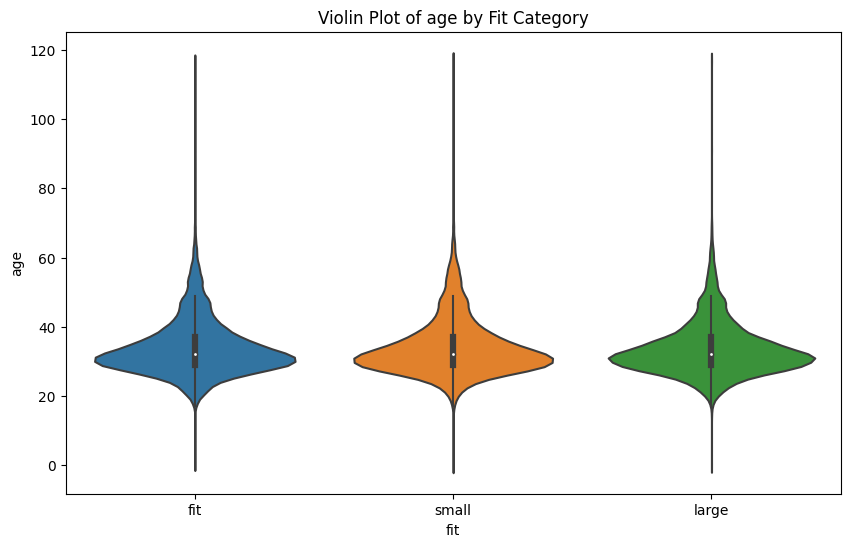

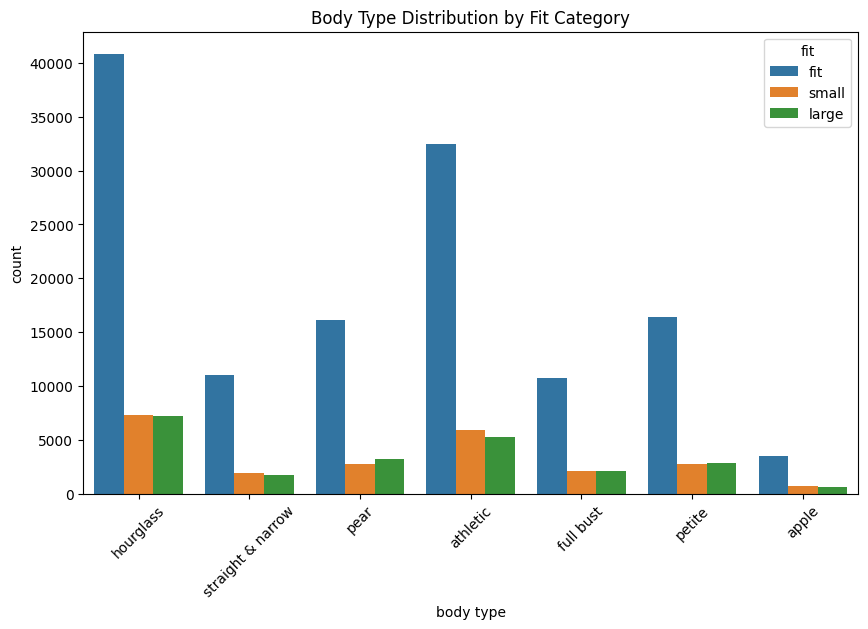

fit                 fit  large  small
category_grouped                     
dress             66567  12631  13686
gown              35177   4467   4737
jumpsuit           3866    646    672
maxi               2605    552    286
other             12019   3083   1938
sheath            14549   1634   3133
shift              3667    892    806
top                3608    802    521


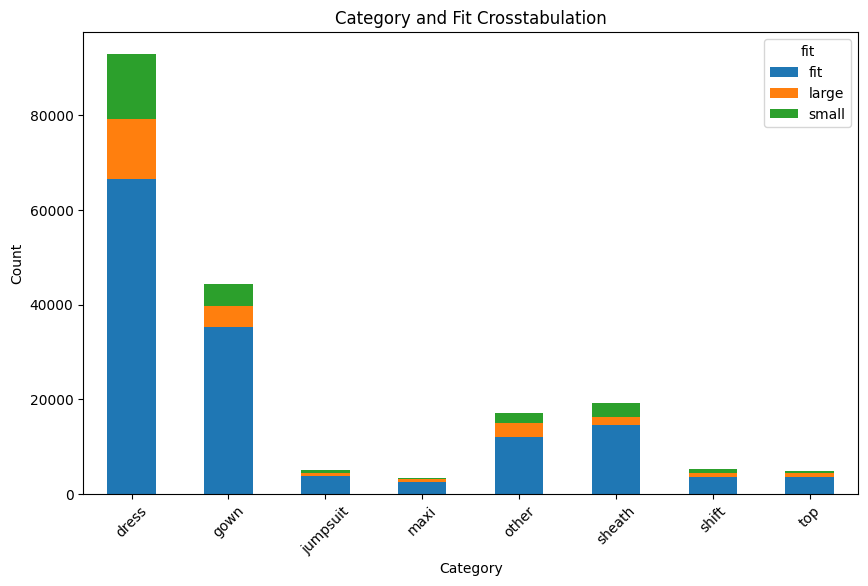

In [ ]:
# More Advanced dataset analysis
# Correlation matrix for numerical features
numerical_features = df.select_dtypes(include=['int64', 'float64'])
corr_matrix = numerical_features.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Pairplot to explore the relationships between numerical features
# This can be resource-intensive if the dataset is large
sns.pairplot(numerical_features)
plt.show()

# Boxplot for numerical features against 'fit'
for column in numerical_features.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='fit', y=column, data=df)
    plt.title(f'Boxplot of {column} by Fit Category')
    plt.show()

# Violin plot for numerical features against 'fit'
for column in numerical_features.columns:
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='fit', y=column, data=df)
    plt.title(f'Violin Plot of {column} by Fit Category')
    plt.show()

# Categorical plot for 'body_type' against 'fit'
plt.figure(figsize=(10, 6))
sns.countplot(x='body type', hue='fit', data=df)
plt.title('Body Type Distribution by Fit Category')
plt.xticks(rotation=45)
plt.show()

# Cross tabulation of 'category' and 'fit'
category_fit_ct = pd.crosstab(df['category_grouped'], df['fit'])
print(category_fit_ct)

# Visualize the crosstabulation
category_fit_ct.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Category and Fit Crosstabulation')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

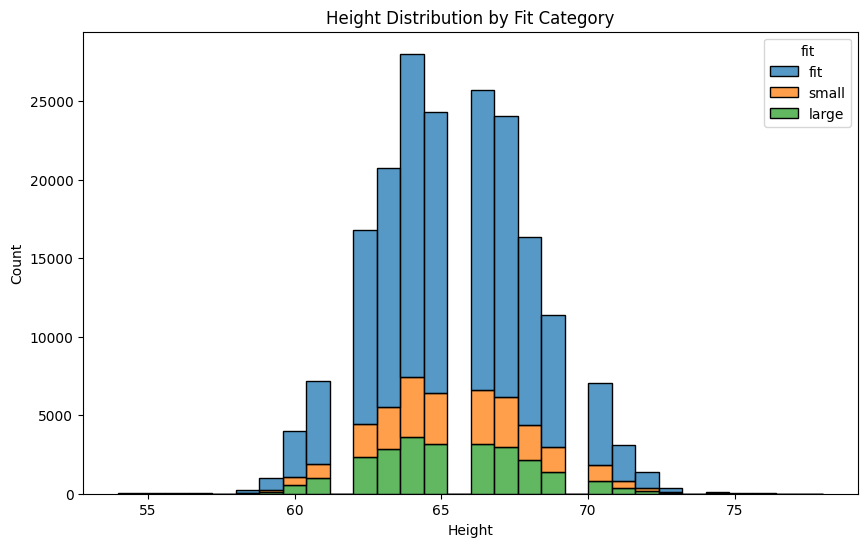

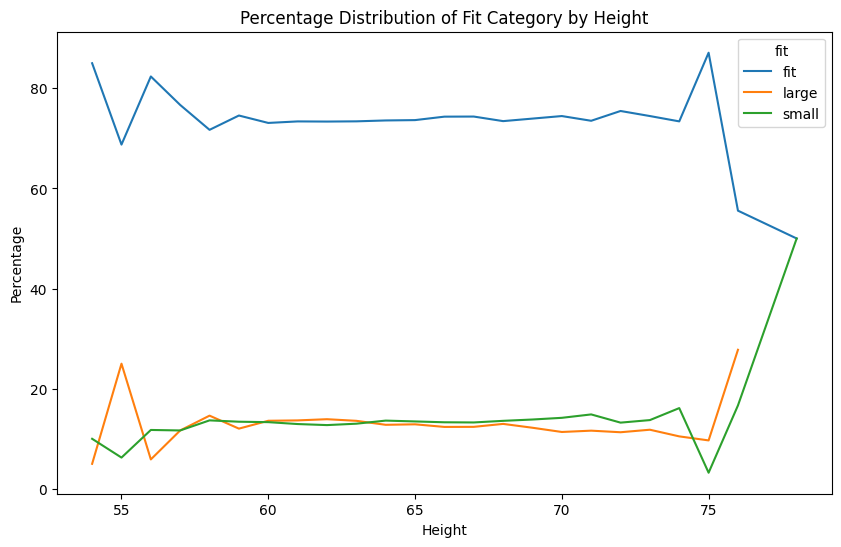

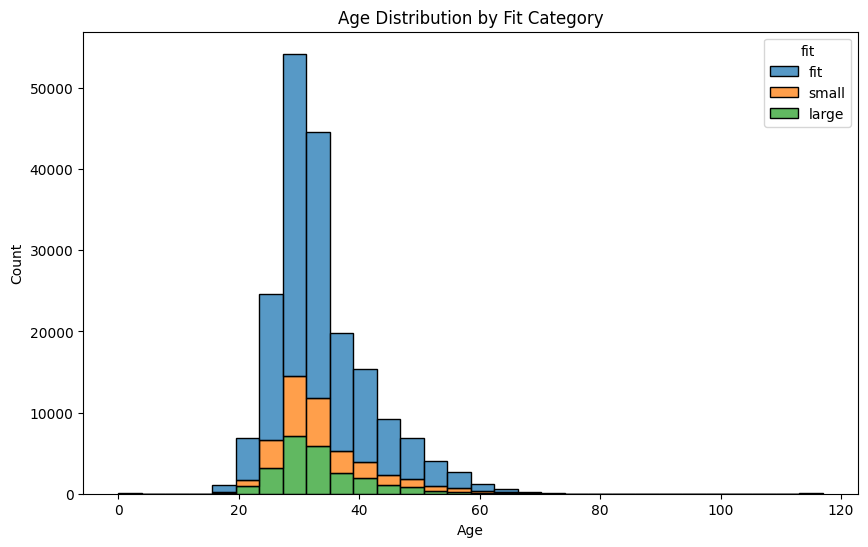

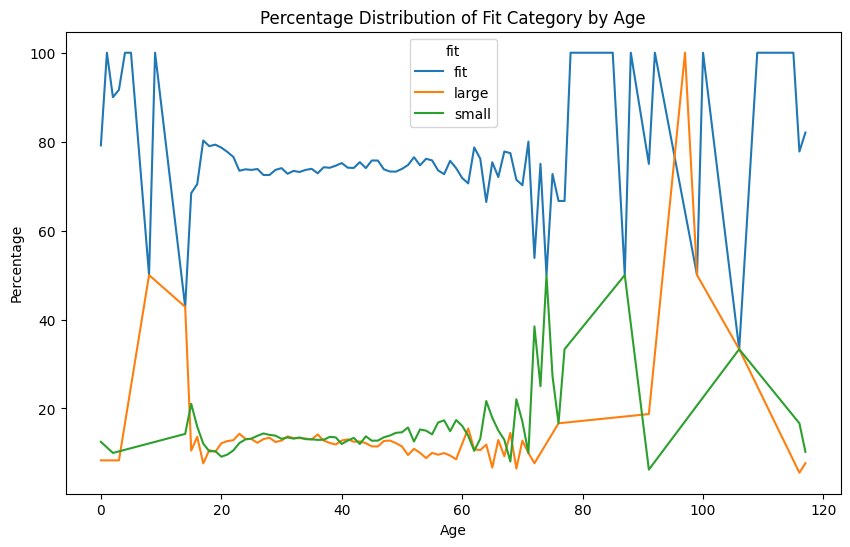

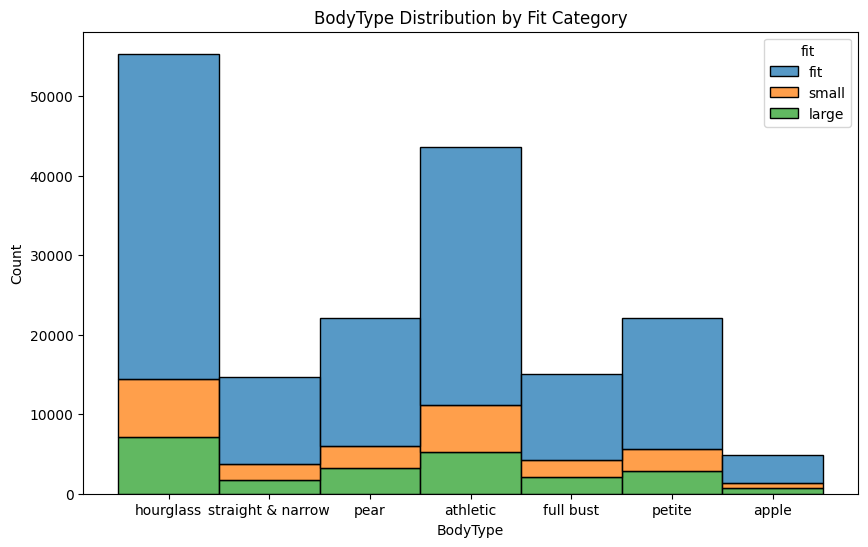

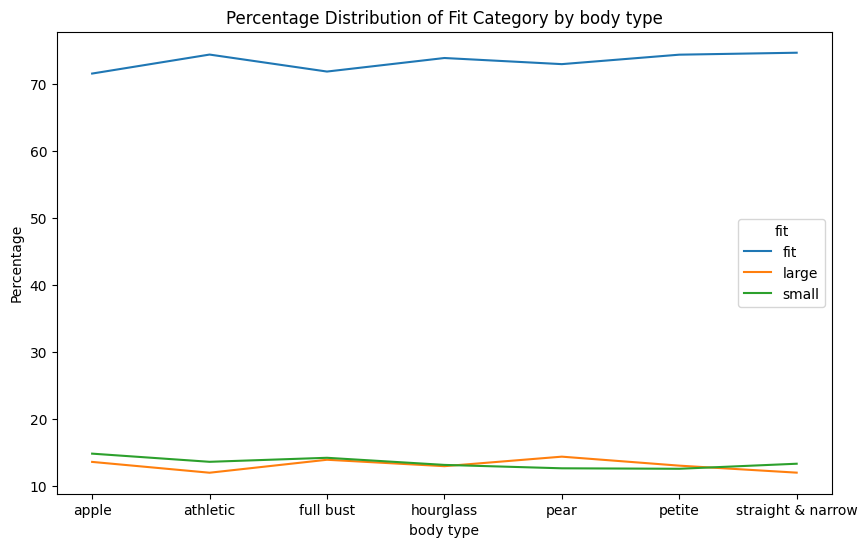

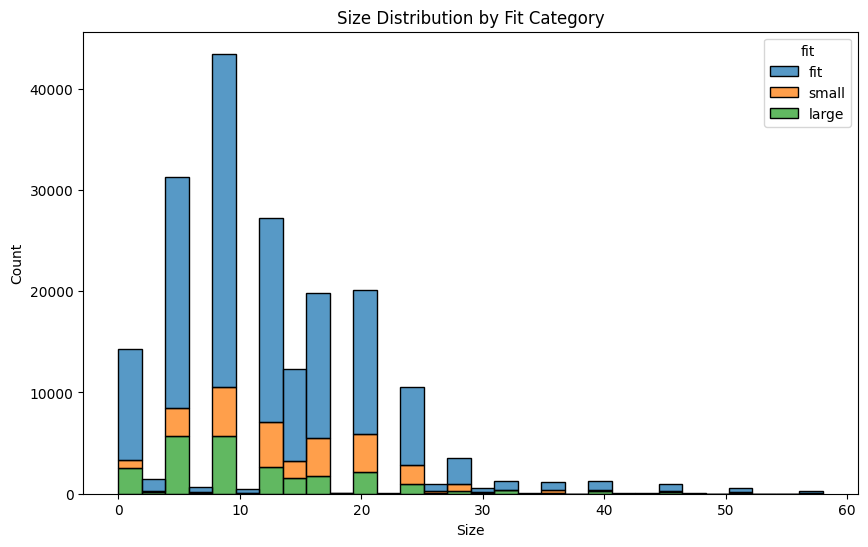

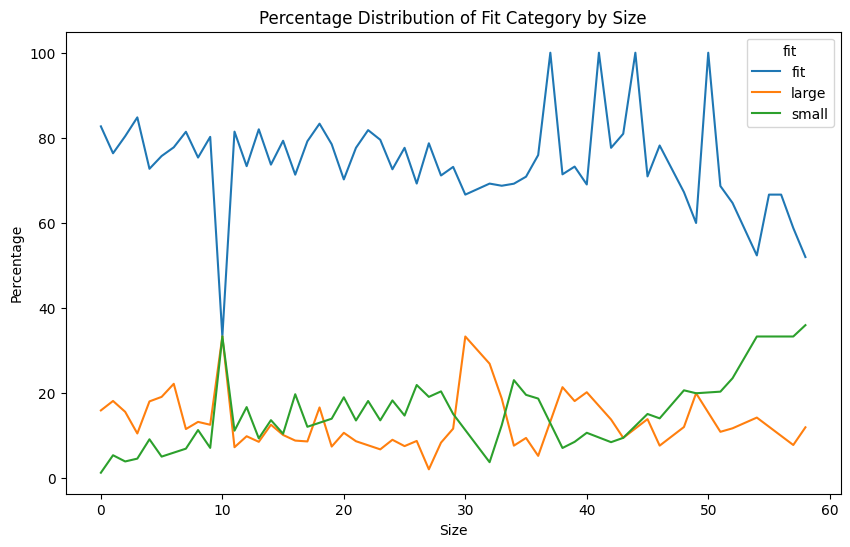

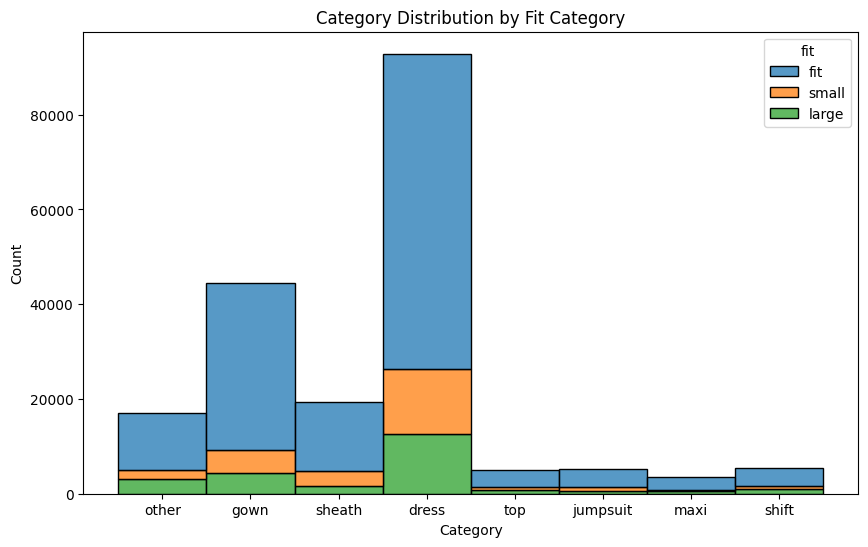

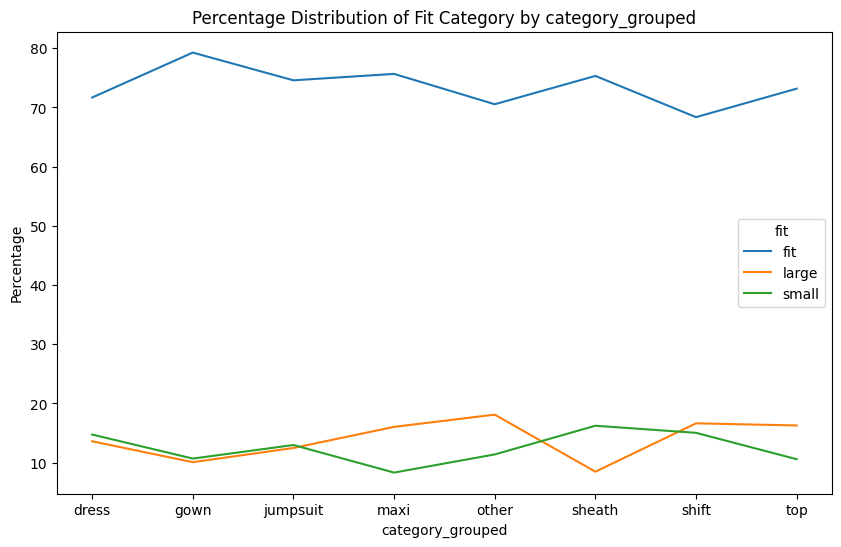

In [ ]:
# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='height', hue='fit', multiple='stack', bins=30)
plt.title('Height Distribution by Fit Category')
plt.xlabel('Height')
plt.ylabel('Count')
plt.show()

## Line
total_counts = df.groupby('height')['fit'].count().reset_index(name='total_count')
frequency_data = df.groupby(['fit', 'height']).size().reset_index(name='count')
frequency_data = frequency_data.merge(total_counts, on='height')
frequency_data['percentage'] = (frequency_data['count'] / frequency_data['total_count']) * 100
plt.figure(figsize=(10, 6))
sns.lineplot(data=frequency_data, x='height', y='percentage', hue='fit')
plt.title('Percentage Distribution of Fit Category by Height')
plt.xlabel('Height')
plt.ylabel('Percentage')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='age', hue='fit', multiple='stack', bins=30)
plt.title('Age Distribution by Fit Category')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

total_counts = df.groupby('age')['fit'].count().reset_index(name='total_count')
frequency_data = df.groupby(['fit', 'age']).size().reset_index(name='count')
frequency_data = frequency_data.merge(total_counts, on='age')
frequency_data['percentage'] = (frequency_data['count'] / frequency_data['total_count']) * 100
plt.figure(figsize=(10, 6))
sns.lineplot(data=frequency_data, x='age', y='percentage', hue='fit')
plt.title('Percentage Distribution of Fit Category by Age')
plt.xlabel('Age')
plt.ylabel('Percentage')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='body type', hue='fit', multiple='stack', bins=30)
plt.title('BodyType Distribution by Fit Category')
plt.xlabel('BodyType')
plt.ylabel('Count')
plt.show()

total_counts = df.groupby('body type')['fit'].count().reset_index(name='total_count')
frequency_data = df.groupby(['fit', 'body type']).size().reset_index(name='count')
frequency_data = frequency_data.merge(total_counts, on='body type')
frequency_data['percentage'] = (frequency_data['count'] / frequency_data['total_count']) * 100
plt.figure(figsize=(10, 6))
sns.lineplot(data=frequency_data, x='body type', y='percentage', hue='fit')
plt.title('Percentage Distribution of Fit Category by body type')
plt.xlabel('body type')
plt.ylabel('Percentage')
plt.show()





plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='size', hue='fit', multiple='stack', bins=30)
plt.title('Size Distribution by Fit Category')
plt.xlabel('Size')
plt.ylabel('Count')
plt.show()


total_counts = df.groupby('size')['fit'].count().reset_index(name='total_count')
frequency_data = df.groupby(['fit', 'size']).size().reset_index(name='count')
frequency_data = frequency_data.merge(total_counts, on='size')
frequency_data['percentage'] = (frequency_data['count'] / frequency_data['total_count']) * 100
plt.figure(figsize=(10, 6))
sns.lineplot(data=frequency_data, x='size', y='percentage', hue='fit')
plt.title('Percentage Distribution of Fit Category by Size')
plt.xlabel('Size')
plt.ylabel('Percentage')
plt.show()


plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='category_grouped', hue='fit', multiple='stack', bins=30)
plt.title('Category Distribution by Fit Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

total_counts = df.groupby('category_grouped')['fit'].count().reset_index(name='total_count')
frequency_data = df.groupby(['fit', 'category_grouped']).size().reset_index(name='count')
frequency_data = frequency_data.merge(total_counts, on='category_grouped')
frequency_data['percentage'] = (frequency_data['count'] / frequency_data['total_count']) * 100
plt.figure(figsize=(10, 6))
sns.lineplot(data=frequency_data, x='category_grouped', y='percentage', hue='fit')
plt.title('Percentage Distribution of Fit Category by category_grouped')
plt.xlabel('category_grouped')
plt.ylabel('Percentage')
plt.show()

In [ ]:

# Histograms for Numerical Distributions
size_df = df['size']
size_df.hist(figsize=(5,5), density=True)
plt.title('Size Distribution')
plt.xlabel('Size')
plt.ylabel('% of Transactions')
plt.show()


In [ ]:

size_df = df['age']
size_df.hist(figsize=(5,5), density=True)
plt.title('Age Distribution ')
plt.xlabel('Age [yrs]')
plt.ylabel('% of Transactions')
plt.show()


In [ ]:

size_df = df['rating']
size_df.hist(figsize=(5,5), density=True)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('% of Transactions')
plt.show()


In [ ]:

size_df = df['height']
size_df.hist(figsize=(5,5), density=True)
plt.title('Height Distribution')
plt.xlabel('Height [in]')
plt.ylabel('% of Transactions')
plt.show()


In [ ]:

size_df = df['weight']
size_df.hist(figsize=(5,5), density=True)
plt.title('Weight Distribution')
plt.xlabel('Weight [lbs]')
plt.ylabel('% of Transactions')
plt.show()


In [ ]:

# Categorical plot for 'body_type' against 'fit' - Normalized 
plt.figure(figsize=(10, 6))
grouped = df.groupby(['body type', 'fit']).size()
normalized = grouped.groupby(level=0).apply(lambda x: 100 * x / x.sum())
normalized.unstack().plot(kind='bar', figsize=(10, 6))
plt.title('Distribution of Fit by Body Type')
plt.xlabel('Body Type')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='Fit')
plt.show()


In [ ]:

# Normalized fit distribution by clothing category
total_counts = df.groupby('category_grouped')['fit'].count().reset_index(name='total_count')
frequency_data = df.groupby(['fit', 'category_grouped']).size().reset_index(name='count')
frequency_data = frequency_data.merge(total_counts, on='category_grouped')
frequency_data['percentage'] = 100 * frequency_data['count'] / frequency_data['total_count']
plt.figure(figsize=(10, 6))
pivot_df = frequency_data.pivot(index='category_grouped', columns='fit', values='percentage')
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Percentage Distribution of Fit Category by category_grouped')
plt.xlabel('category_grouped')
plt.ylabel('Percentage')
plt.show()
